
# Basic Overview
The objective is to build go through data, validate it and test out random forest techniques on the same.

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
import pandas as pd
import numpy as np

In [3]:
import sys
sys.path.append('../common_routines/')
import numpy as np
from relevant_functions import\
    fit_pipeline_and_cross_validate, \
    get_validated_transformed_data


In [139]:
import matplotlib.pyplot as plt
FIGURE_LENGTH = 16
FIGURE_BREADTH = 9


### Master plan
The main question that comes up here is as to how to handle huge number of predictors (since randomForest does not have automatic shrinkage). Our idea is  the following :

1. Build a randomForest model using each of the predictor alone and use the cross validation score obtained to 'rank' the predictors.
2. Using the rank computed in the step above, see the cross validation score obtained , say when we include top 10 predictors, top 20 predictors etc, and hopefully arrive at an equilibrium value.

The main motivation here is that hopefully, the non parametric nature of the method, couple with our 'dimensionality control' technique can give us something interesting .Let us see !

#### First set up, set up data properly

In [4]:
complete_train_data = get_validated_transformed_data("../input/train.csv")

In [5]:
complete_train_data_one_hot = pd.get_dummies(complete_train_data)
train_data_one_hot = complete_train_data_one_hot[:(1460 - 365)].copy()
test_data_one_hot = complete_train_data_one_hot[(1460 - 365):].copy()

#### Set up pipelines appropriately

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
def get_random_forest_pipeline():
    my_pipe = Pipeline([('missing', Imputer(strategy='mean')),

                        ('model', RandomForestRegressor(random_state=0))
                        ])
    return my_pipe

In [9]:
predictor_cols = [col for col in train_data_one_hot.columns if col not in ['SalePrice']]


In [55]:

(my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
    get_random_forest_pipeline(), 
    train_data_one_hot, predictor_cols[3:4])
print(predictor_cols[3:4])
print("Cross validation score is {0}".format(cross_validation_score))

['OverallQual']
Cross validation score is 0.23010272781191557


In [58]:
predictor_cols[0:1]

['Id']

#### Checking out the model

The issue here is that randomForest does not do  shrinkage by default. Hence let us see how many features are being used up by the current model.

In [8]:
from relevant_functions import print_model_stats_from_pipeline

In [22]:
model_obj = my_pipe.named_steps['model']

In [25]:
model_obj

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
model_obj.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=209652396, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=398764591, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=924231285, splitter='best'),
 DecisionTreeRegressor

In [26]:
model_obj.n_features_

271

Comment : We can see that all features are used, resulting in this being a chronic example of overfitting. 
The question here is whether there is any easy way for us to select only of the most important predictors.

As mentioned earlier, let us get cross validation scores for each predictor in itself and see what we get, if we select few of the best predictors(as per this score)

In [61]:
def get_cross_validation_score(predictor_col_index, 
                               train_data_one_hot=train_data_one_hot, 
                               predictor_cols=predictor_cols):
    (my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
        get_random_forest_pipeline(), 
        train_data_one_hot, predictor_cols[predictor_col_index:predictor_col_index + 1])
    return cross_validation_score


#### Analyze and plot the predictive power of each column

This way, it will be easier for us to select the ones with the higher power

Defining some functions to make life easy !

In [134]:
def get_relevant_df(index_name='predictor_index', 
                    compute_func=get_cross_validation_score,
                    index_start=0,
                    predictor_cols=predictor_cols):
    NUM_POINTS = len(predictor_cols)
    predictor_index_cross_val_score_df = pd.DataFrame(np.arange(index_start,NUM_POINTS + index_start), columns=[index_name])
    predictor_index_cross_val_score_df['cross_val_score'] = \
        predictor_index_cross_val_score_df[index_name].apply(lambda x : compute_func(x))
    predictor_index_cross_val_score_df.index = predictor_index_cross_val_score_df[index_name]
    predictor_index_cross_val_score_df.drop(columns=[index_name], inplace=True)
    return predictor_index_cross_val_score_df

In [136]:
def plot_relevant_df(predictor_index_cross_val_score_df, 
                    title='Cross Validation score vs Predictor column index',
                    fig_length=FIGURE_LENGTH,
                    fig_breadth=FIGURE_BREADTH):
    fig, ax = plt.subplots(1, 1, figsize=(fig_length, fig_breadth))
    predictor_index_cross_val_score_df.plot(ax=ax)
    ax.set_title(title)    

In [124]:
predictor_index_cross_val_score_df = get_relevant_df()

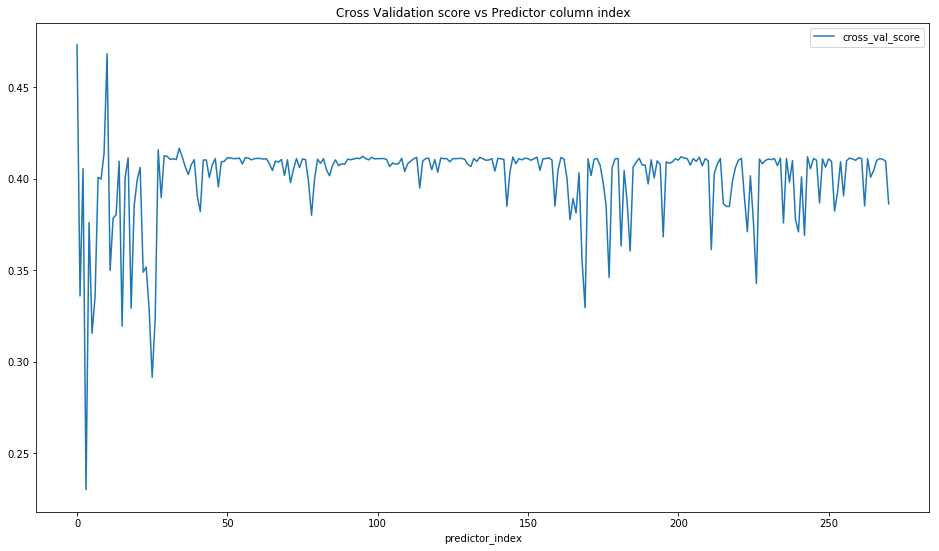

In [126]:
plot_relevant_df(predictor_index_cross_val_score_df) 

#### Sort the dataframe by predictive power of predictors

In [127]:
## Sort the dataframe for easy visibilty
predictor_index_cross_val_score_df.sort_values(by=['cross_val_score'],inplace=True)

### Facilitate computation of cross validation score with a specified number of top predictors.

The idea here is to find the cross validation score when a specified number of best predictors are included and plot this as a curve. From this, we hope to find the 'equilibrium' number of predictors, which would maximize the cross validation score

In [132]:
def get_cross_val_score_with_best_predictors(num_predictors_to_include=5,
                                             predictor_index_cross_val_score_df=predictor_index_cross_val_score_df,
                                             predictor_cols=predictor_cols,
                                             train_data_one_hot=train_data_one_hot):
    if num_predictors_to_include != 0 :
        cols_array = predictor_index_cross_val_score_df.index[0:num_predictors_to_include].values
    else:
        cols_array = []
    rel_cols = [predictor_cols[i] for i in cols_array]
    (my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
        get_random_forest_pipeline(), 
        train_data_one_hot, rel_cols)
    return cross_validation_score

In [137]:
num_predictors_cross_val_score_df = get_relevant_df(index_name='num_predictors',
                                                    compute_func=get_cross_val_score_with_best_predictors,
                                                    index_start=1)

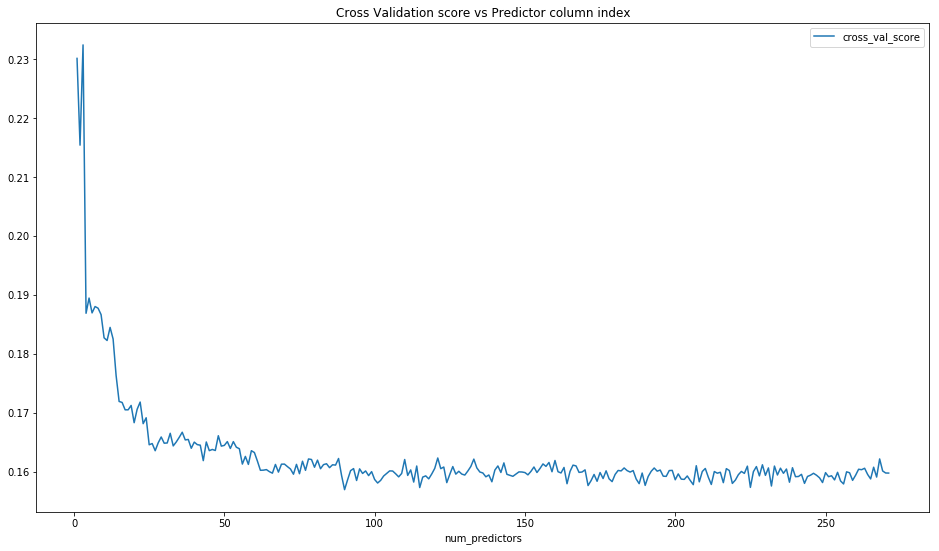

In [138]:
plot_relevant_df(num_predictors_cross_val_score_df) 

Comment : As it can be seen, the score plateaus to the range of 0.16 almost immediately, giving us not much of a benefit.